<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/dataset/notebooks/2.0-mb-data_preprocessing_loading_splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run `pip install .` first to install all dependencies.

In [1]:
from catboost import CatBoostClassifier, Pool

# import gcsfs
# import google.auth
# from google.colab import auth

from numpy.testing import assert_almost_equal
import numpy as np
from pandas._testing.asserters import assert_almost_equal
import pandas as pd

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

#import shap

#from tqdm.notebook import tqdm

# import wandb

import sys

sys.path.append("..")


## Adversarial Validation
> Adversarial Validation is a technique allowing you to easily estimate the degree of difference between your training and test data. This technique was long rumored among Kaggle participants and transmitted from team to team until it emerged publicly thanks to a post by Zygmunt Zając (https://www.kaggle.com/zygmunt) on his FastML blog. (adapted from Banchawicz et. al)

In [2]:
train = pd.read_parquet(
    "../artifacts/classical_size_features_log_normalized:v0/train_set_60.parquet"
)

val = pd.read_parquet(
    "../artifacts/classical_size_features_log_normalized:v0/val_set_20.parquet"
)


In [3]:
# randomly sample 10 % of rows
train = train.sample(frac=0.1, random_state=42)
val = val.sample(frac=0.1, random_state=42)


In [4]:
train.head().T


,3249281,11026460,11754654,12792033,27061954
TRADE_PRICE,-0.693407,-0.492171,-0.952182,-0.618186,-0.572859
bid_ask_size_ratio_ex,-0.999988,-0.997340,-0.999969,-0.998098,-0.999844
rel_bid_size_ex,-0.999985,-0.999997,-0.999999,-1.000000,-0.999998
rel_ask_size_ex,-0.999994,-0.999773,-0.999999,-0.999977,-0.999989
rel_ask_ex,-0.448436,-0.448436,-0.448436,-0.448436,-0.449363
rel_bid_ex,0.448436,0.448436,0.448436,0.448436,0.449363
BEST_rel_bid,-0.220870,-0.220870,-0.220870,-0.220870,-0.221566
BEST_rel_ask,0.220869,0.220869,0.220869,0.220869,0.221565
bid_ask_ratio_ex,-0.619512,-0.607547,-0.800000,-0.606667,-0.610667
chg_ex_lead,0.172051,0.172650,0.172301,0.172541,0.172279


In [28]:

# train = train.drop(["buy_sell"], axis=1)
# test = test.drop(["buy_sell"], axis=1)

# https://stackoverflow.com/a/34879805/5755604
y_train = train[["buy_sell"]]
y_val = val[["buy_sell"]]
X_train = train.drop(["buy_sell"], axis=1)
X_val = val.drop(["buy_sell"], axis=1)

X = pd.concat([train, val], axis=0).drop(["buy_sell"], axis=1)

rand_order = np.random.permutation(len(X))
X = X.iloc[rand_order]
# assign zeros to train set and ones to test set
y = pd.Series([0] * len(train) + [1] * len(val))
y = y.iloc[rand_order]


In [6]:
print(X.dtypes)


TRADE_PRICE              float64
bid_ask_size_ratio_ex    float64
rel_bid_size_ex          float64
rel_ask_size_ex          float64
rel_ask_ex               float64
rel_bid_ex               float64
BEST_rel_bid             float64
BEST_rel_ask             float64
bid_ask_ratio_ex         float64
chg_ex_lead              float64
chg_ex_lag               float64
chg_all_lead             float64
chg_all_lag              float64
ask_ex                   float64
bid_ex                   float64
BEST_ASK                 float64
BEST_BID                 float64
price_all_lag            float64
price_all_lead           float64
price_ex_lag             float64
price_ex_lead            float64
TRADE_SIZE               float64
bid_size_ex              float64
ask_size_ex              float64
dtype: object


In [7]:
train.head()

,TRADE_PRICE,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,rel_ask_ex,rel_bid_ex,BEST_rel_bid,BEST_rel_ask,bid_ask_ratio_ex,chg_ex_lead,...,BEST_ASK,BEST_BID,price_all_lag,price_all_lead,price_ex_lag,price_ex_lead,TRADE_SIZE,bid_size_ex,ask_size_ex,buy_sell
3249281,-0.693407,-0.999988,-0.999985,-0.999994,-0.448436,0.448436,-0.220870,0.220869,-0.619512,0.172051,...,-0.817281,-0.700130,-0.747425,-0.815041,-0.677773,-0.688231,-0.785049,-0.177238,-0.091263,1
11026460,-0.492171,-0.997340,-0.999997,-0.999773,-0.448436,0.448436,-0.220870,0.220869,-0.607547,0.172650,...,-0.698421,-0.494246,-0.614574,-0.685868,-0.554139,-0.524245,-0.785049,0.129390,-0.688739,-1
11754654,-0.952182,-0.999969,-0.999999,-0.999999,-0.448436,0.448436,-0.220870,0.220869,-0.800000,0.172301,...,-0.970126,-0.973581,-0.969651,-0.975721,-0.981257,-0.969624,-1.000000,0.072858,-0.004580,1
12792033,-0.618186,-0.998098,-1.000000,-0.999977,-0.448436,0.448436,-0.220870,0.220869,-0.606667,0.172541,...,-0.772852,-0.619214,-0.718854,-0.772719,-0.559736,-0.649317,-1.000000,0.191455,-0.583443,-1
27061954,-0.572859,-0.999844,-0.999998,-0.999989,-0.449363,0.449363,-0.221566,0.221565,-0.610667,0.172279,...,-0.744694,-0.573990,-0.618286,-0.733019,-0.629438,-0.588061,-1.000000,-0.113006,-0.463031,1


In [8]:
X.head()

,TRADE_PRICE,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,rel_ask_ex,rel_bid_ex,BEST_rel_bid,BEST_rel_ask,bid_ask_ratio_ex,chg_ex_lead,...,bid_ex,BEST_ASK,BEST_BID,price_all_lag,price_all_lead,price_ex_lag,price_ex_lead,TRADE_SIZE,bid_size_ex,ask_size_ex
3297308,-0.832101,-0.999984,-0.999988,-0.999994,-0.448436,0.448436,-0.220870,0.220869,-0.623529,0.172377,...,-0.837067,-0.899200,-0.837069,-0.844123,-0.907820,-0.801138,-0.857771,-0.666454,-0.018062,0.020580
5309536,-0.412365,-0.999982,-0.999898,-0.999938,-0.450753,0.450753,-0.222609,0.222608,-0.605333,0.171778,...,-0.410061,-0.649344,-0.410067,-0.540461,-0.632369,-0.456997,-0.417083,-0.864381,-0.583443,-0.568327
16558280,-0.393225,-0.999999,-0.999894,-0.999996,-0.449594,0.449594,-0.222029,0.222028,-0.619512,0.173085,...,-0.397166,-0.636377,-0.394040,-0.518106,-0.622207,-0.353928,-0.436012,-0.666454,-0.392594,0.085060
25506968,-0.894003,-0.999824,-0.999996,-0.999978,-0.449981,0.449981,-0.222609,0.222608,-0.624000,0.172290,...,-0.893207,-0.933563,-0.891328,-0.916341,-0.936655,-0.893271,-0.907905,-0.864381,-0.024900,-0.397940
17182570,-0.899684,-0.999990,-0.999660,-0.999891,-0.450753,0.450753,-0.222609,0.222608,-0.672727,0.172051,...,-0.897004,-0.933563,-0.897005,-0.926936,-0.931895,-0.906787,-0.874021,-0.439990,-0.382373,-0.257067


In [9]:
import seaborn as sns
from typing import Optional, List
import matplotlib.pyplot as plt

In [10]:
def plot_kde_target_comparsion(
    data: pd.DataFrame,
    var_name: str,
    clip: Optional[List[float]] = None,
    years: List[int] = [2006, 2010, 2013],
) -> None:
    """
    Plot several kde plots side by side for the feature.

    Args:
        var_name (str): name of the feature
        clip (Optional[List[float]], optional): clipping range. Defaults to None.
        years (List[int], optional): years to compare. Defaults to [2006, 2010, 2013].
    """
    corr_var = data["buy_sell"].corr(data[var_name])

    median_sell = data[data["buy_sell"] == -1][var_name].median()
    median_buy = data[data["buy_sell"] == 1][var_name].median()

    _, ax = plt.subplots()
    for i in [-1, 1]:
        sns.kdeplot(
            data=data[data["buy_sell"] == i],
            x=var_name,
            clip=clip,
            label=str(i),
            cumulative=False,
            common_grid=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()
    print(
        f"The correlation between '{var_name}' and the 'buy_sell' is {corr_var: 0.4f}"
    )
    print(f"Median value of sells = {median_sell: 0.4f}")
    print(f"Median value of buys = {median_buy: 0.4f}")


### Metrics

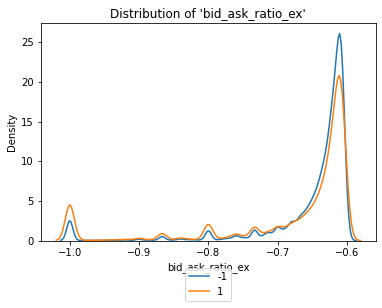

The correlation between 'bid_ask_ratio_ex' and the 'buy_sell' is -0.1446
Median value of sells = -0.6235
Median value of buys = -0.6273


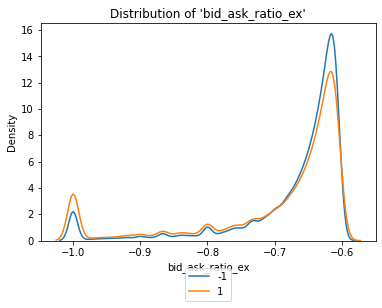

The correlation between 'bid_ask_ratio_ex' and the 'buy_sell' is -0.1125
Median value of sells = -0.6381
Median value of buys = -0.6465


In [11]:
plot_kde_target_comparsion(train,"bid_ask_ratio_ex")
plot_kde_target_comparsion(val,"bid_ask_ratio_ex")

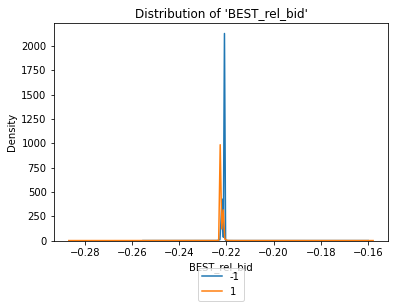

The correlation between 'BEST_rel_bid' and the 'buy_sell' is  0.2835
Median value of sells = -0.2221
Median value of buys = -0.2214


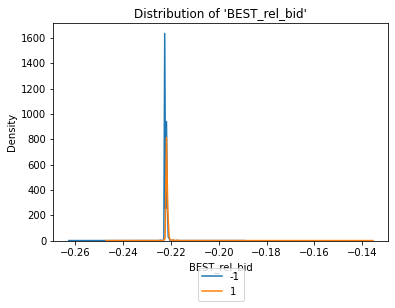

The correlation between 'BEST_rel_bid' and the 'buy_sell' is  0.1664
Median value of sells = -0.2218
Median value of buys = -0.2217


In [12]:
plot_kde_target_comparsion(train,"BEST_rel_bid")
plot_kde_target_comparsion(val,"BEST_rel_bid")

In [13]:
# perform cv with catboost classifier
#cat_features = ["OPTION_TYPE", "UNDERLYING_SYMBOL", "ROOT"]

model = CatBoostClassifier(
    task_type="GPU",
    #cat_features=cat_features,
    logging_level="Silent",
)


In [14]:
X.columns

Index(['TRADE_PRICE', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'rel_ask_ex', 'rel_bid_ex', 'BEST_rel_bid',
       'BEST_rel_ask', 'bid_ask_ratio_ex', 'chg_ex_lead', 'chg_ex_lag',
       'chg_all_lead', 'chg_all_lag', 'ask_ex', 'bid_ex', 'BEST_ASK',
       'BEST_BID', 'price_all_lag', 'price_all_lead', 'price_ex_lag',
       'price_ex_lead', 'TRADE_SIZE', 'bid_size_ex', 'ask_size_ex'],
      dtype='object')

In [15]:
cv_preds = cross_validate(model, X, y, cv=5, return_estimator = True)

In [16]:
model_from_cv = cv_preds["estimator"][0]

In [17]:
print("accurcies (test):")
print(cv_preds["test_score"])

accurcies (test):
[0.79890169 0.79959687 0.79858371 0.79910986 0.79997026]


In [18]:
feature_importance = model_from_cv.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,BEST_rel_ask,11.139304
1,bid_ask_ratio_ex,10.916485
2,chg_all_lag,8.761686
3,ask_ex,8.756247
4,chg_all_lead,8.142264
5,BEST_rel_bid,7.593875
6,rel_ask_ex,6.995917
7,bid_size_ex,6.914391
8,ask_size_ex,5.819906
9,rel_bid_ex,5.242062


In [19]:
cv_preds

{'fit_time': array([16.60381603, 16.13292909, 16.00001359, 16.07746768, 16.23855948]),
 'score_time': array([0.36630225, 0.31348348, 0.3462038 , 0.30711889, 0.28152966]),
 'estimator': [<catboost.core.CatBoostClassifier at 0x14d3195ff4f0>,
 'test_score': array([0.79890169, 0.79959687, 0.79858371, 0.79910986, 0.79997026])}

Remove very important columns.

In [20]:
# strip ratio, rel bid, rel ask, and reformulate later
columns_stripped = ['TRADE_PRICE', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'chg_ex_lead', 'chg_ex_lag',
       'chg_all_lead', 'chg_all_lag', 'ask_ex', 'bid_ex', 'BEST_ASK',
       'BEST_BID', 'price_all_lag', 'price_all_lead', 'price_ex_lag',
       'price_ex_lead', 'TRADE_SIZE', 'bid_size_ex', 'ask_size_ex']

In [63]:
cv_preds = cross_validate(model, X[columns_stripped], y, cv=5, return_estimator = True)

In [64]:
model_from_cv = cv_preds["estimator"][0]

In [65]:
print("accurcies (val):")
print(cv_preds["test_score"])

accurcies (val):
[0.63446678 0.63428777 0.63487521 0.63407599 0.63519541]


In [24]:
feature_importance = model_from_cv.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,chg_all_lag,22.311764
1,chg_all_lead,20.677176
2,bid_size_ex,7.854769
3,ask_ex,6.908875
4,ask_size_ex,6.840852
5,chg_ex_lag,6.397396
6,chg_ex_lead,5.374900
7,price_ex_lead,4.212533
8,price_ex_lag,3.572380
9,bid_ex,3.309540


In [29]:
# removal
model.fit(X_train[columns_stripped],y_train)
model.score(X_val[columns_stripped],y_val)

0.6799269720347646

In [30]:
# no removal
model.fit(X_train,y_train)
model.score(X_val,y_val)

0.7320250003814135

In [37]:
X_train.index.values

array([ 3249281, 11026460, 11754654, ...,   338704,  1793973,  3360776])

In [38]:
# https://catboost.ai/en/docs/concepts/python-reference_pool
# FIXME: data is already shuffled!
train_pool = Pool(data=X_train, label=y_train,timestamp=X_train.index.values)

In [39]:
model.fit(train_pool)
model.score(X_val,y_val)

0.7320728042026678

In [40]:
y_train.head()

,buy_sell
3249281,1
11026460,-1
11754654,1
12792033,-1
27061954,1


In [41]:
# restore original order and keep the latest > tail(1.000.000)
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

/scratch/slurm_tmpdir/job_21400006/ipykernel_3412713/65818325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.sort_index(inplace=True)


In [48]:
# improvement by > 0.6 % 
model.fit(X_train.tail(1000000),y_train.tail(1000000))
model.score(X_val,y_val)

0.738414438788224

In [58]:
# new adversarial validation
X_train_latest = X_train.tail(1000000)

X = pd.concat([X_train_latest, X_val], axis=0)

rand_order = np.random.permutation(len(X))
X = X.iloc[rand_order]
# assign zeros to train set and ones to test set
y = pd.Series([0] * len(X_train_latest) + [1] * len(X_val))
y = y.iloc[rand_order]


In [59]:
cv_preds = cross_validate(model, X, y, cv=5, return_estimator = True)

In [60]:
model_from_cv = cv_preds["estimator"][0]

In [62]:
print("accurcies (val):")
print(cv_preds["test_score"])

accurcies (val):
[0.67355037 0.67397141 0.67405966 0.67447061 0.67454373]


In [84]:
#weights = list(range(len(y_train)))
weights = np.geomspace(0.001, 1, num=len(y_train))
print(weights[0:10])
train_pool = Pool(X_train, y_train, weight=weights, timestamp=timestamps)

[0.001      0.001      0.001      0.00100001 0.00100001 0.00100001
 0.00100001 0.00100002 0.00100002 0.00100002]


In [85]:
# https://numpy.org/doc/stable/reference/generated/numpy.geomspace.html
model.fit(train_pool)
model.score(X_val,y_val)

0.7390613160290281

In [86]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,ask_size_ex,13.430054
1,bid_size_ex,12.251717
2,rel_bid_ex,10.823827
3,rel_ask_ex,10.724542
4,BEST_rel_ask,9.638005
5,BEST_rel_bid,8.217261
6,rel_bid_size_ex,7.290469
7,bid_ask_size_ratio_ex,6.365288
8,rel_ask_size_ex,5.116696
9,bid_ask_ratio_ex,2.680329


In [ ]:
# optionally set_baseline prediction
